In [1]:
! wget "https://osf.io/drjhb/download"

--2023-07-03 05:00:18--  https://osf.io/drjhb/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.ca-1.osf.io/v1/resources/hygbm/providers/osfstorage/6106c66bb2d332010cffac63?action=download&direct&version=1 [following]
--2023-07-03 05:00:19--  https://files.ca-1.osf.io/v1/resources/hygbm/providers/osfstorage/6106c66bb2d332010cffac63?action=download&direct&version=1
Resolving files.ca-1.osf.io (files.ca-1.osf.io)... 35.241.38.243
Connecting to files.ca-1.osf.io (files.ca-1.osf.io)|35.241.38.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1301492495 (1.2G) [application/octet-stream]
Saving to: ‘download.1’

download.1          100%[===================>]   1.21G  12.5MB/s    in 1m 42s  

2023-07-03 05:02:02 (12.2 MB/s) - ‘download.1’ saved [1301492495/1301492495]



In [2]:
import os
import json
import math
import librosa

import requests
import pickle

# for progress bar
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

# Download Dataset

In [3]:
ZIP_FILE = "download"
if ZIP_FILE in os.listdir():
  print("Dataset file already exist")
else:
  print("Finding the link to web.....")
  try:
    request = requests.get('https://osf.io/drjhb/download')
  except requests.ConnectionError as err:
    print(f"Error: {err}")
  with open(ZIP_FILE, 'wb') as file:
    file.write(request.content)

Dataset file already exist


In [4]:
# unzip the dataset
from zipfile import ZipFile
with ZipFile(ZIP_FILE, "r") as zipObj:
  zipObj.extractall()

In [5]:
os.listdir()

['.config',
 'my_cnn_model_for_mfcc.h5',
 'download.1',
 'download',
 'Data',
 'model_linear.png',
 'sample_data']

In [6]:
import pathlib
DATASET_DIR = "/content/Data/images_original"


In [7]:

import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
CLASSES = os.listdir(DATASET_DIR)

In [8]:
image_generator = ImageDataGenerator(rescale=1./255)

dataset = image_generator.flow_from_directory(directory=str(DATASET_DIR),
                                                     batch_size=32,
                                                     shuffle=True,
                                                     target_size=(244, 244),
                                                     classes = CLASSES)

Found 999 images belonging to 10 classes.


In [9]:
img_height=244
img_width=244
batch_size=8

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_DIR,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 999 files belonging to 10 classes.
Using 800 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_DIR,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 999 files belonging to 10 classes.
Using 199 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


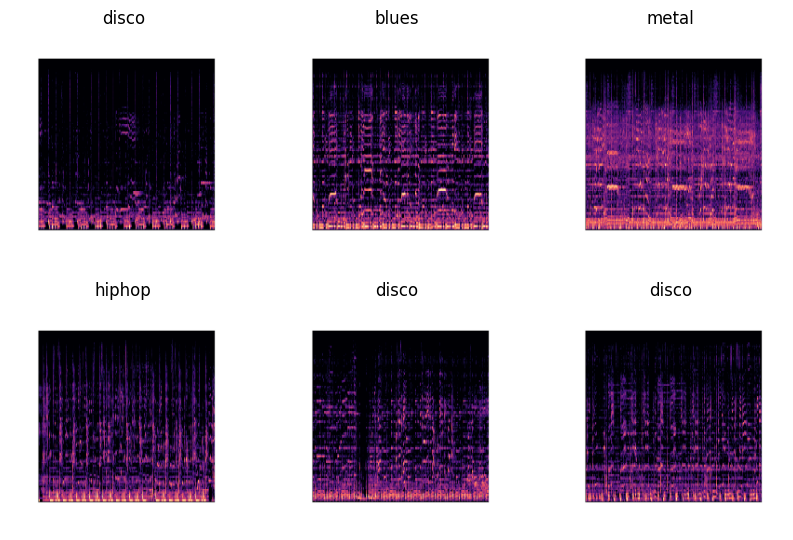

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    try:
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")
    except:
      break

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 244, 244, 3)
(8,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
print(f"Train_ds shape: {train_ds.element_spec}")
print(f"Val_ds shape: {val_ds.element_spec}")

Train_ds shape: (TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Val_ds shape: (TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [18]:
num_classes = len(class_names)

model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='leaky_relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='leaky_relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='leaky_relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 244, 244, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 244, 244, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 122, 122, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 16)        4

In [19]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[model_checkpoint_callback ]
)

Epoch 1/20
100/100 [==============================] - 17s 35ms/step - loss: 2.2945 - accuracy: 0.1225 - val_loss: 2.2295 - val_accuracy: 0.2261
Epoch 2/20
100/100 [==============================] - 2s 22ms/step - loss: 2.1155 - accuracy: 0.2650 - val_loss: 2.0168 - val_accuracy: 0.1910
Epoch 3/20
100/100 [==============================] - 2s 21ms/step - loss: 1.8957 - accuracy: 0.3113 - val_loss: 1.8989 - val_accuracy: 0.2211
Epoch 4/20
100/100 [==============================] - 2s 22ms/step - loss: 1.6696 - accuracy: 0.4175 - val_loss: 1.6556 - val_accuracy: 0.4171
Epoch 5/20
100/100 [==============================] - 2s 21ms/step - loss: 1.5115 - accuracy: 0.4787 - val_loss: 1.5167 - val_accuracy: 0.4171
Epoch 6/20
100/100 [==============================] - 2s 23ms/step - loss: 1.3437 - accuracy: 0.5425 - val_loss: 1.4130 - val_accuracy: 0.4623
Epoch 7/20
100/100 [==============================] - 2s 22ms/step - loss: 1.2565 - accuracy: 0.5700 - val_loss: 1.4575 - val_accuracy: 0.467

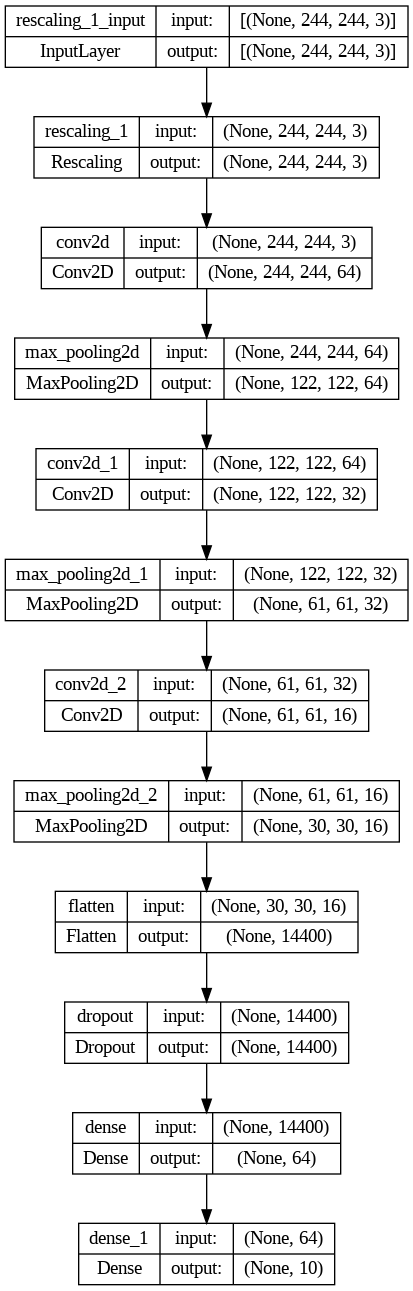

In [21]:
tf.keras.utils.plot_model(
    model,
    to_file='model_linear.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

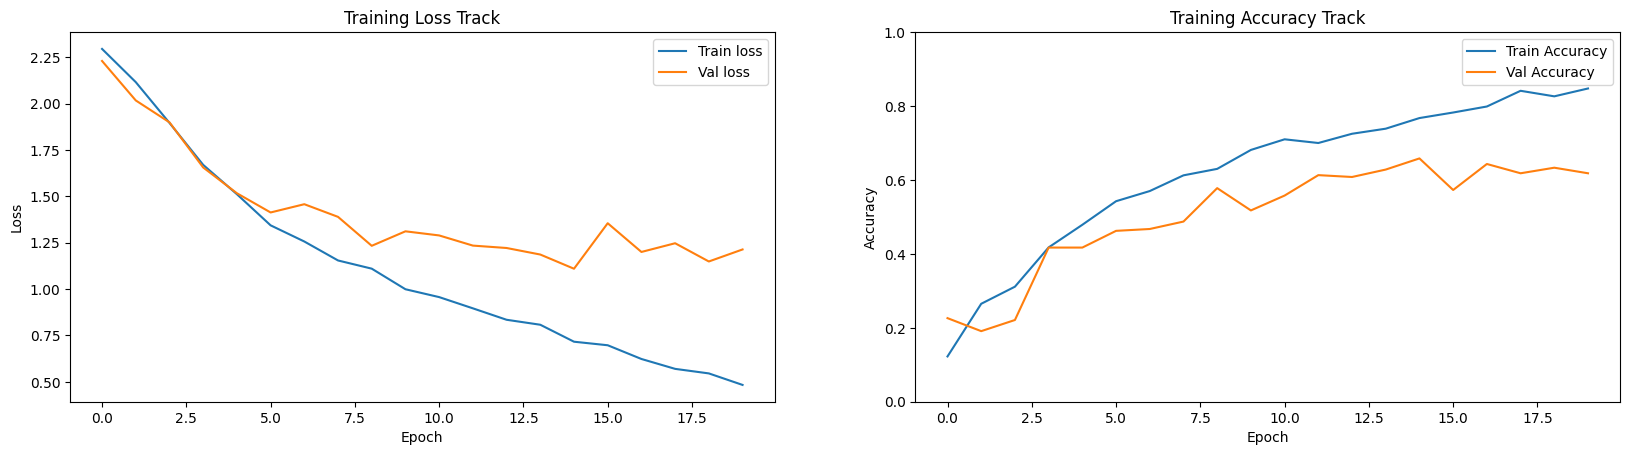

In [22]:
def polt_history(history):

  fig, ax = plt.subplots(1, 2)
  fig.set_figwidth(20)
  epochs = np.arange(0, len(history["loss"]), 1)

  ax[0].plot(epochs, history["loss"], label="Train loss")
  ax[0].plot(epochs, history["val_loss"], label="Val loss")
  ax[0].set_xlabel("Epoch")
  ax[0].set_ylabel("Loss")
  ax[0].set_title("Training Loss Track")
  ax[0].legend()

  ax[1].plot(epochs, history["accuracy"], label="Train Accuracy")
  ax[1].plot(epochs, history["val_accuracy"], label="Val Accuracy")
  ax[1].set_xlabel("Epoch")
  ax[1].set_ylabel("Accuracy")
  ax[1].set_title("Training Accuracy Track")
  ax[1].set_ylim(0, 1)
  ax[1].legend()

  plt.show()

history = model.history
polt_history(history.history)